In [3]:

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great-circle distance between two points on the Earth.
    Args:
        lat1, lon1: Latitude and longitude of point 1 in decimal degrees.
        lat2, lon2: Latitude and longitude of point 2 in decimal degrees.
    Returns:
        Distance in kilometers.
    """
    import math
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def parse_ruptjson(file):
    """
    Parse a JSON file containing rupture data.
    Args:
        file: Path to the JSON file.
    Returns:
        coordinates, length, width
        coordinates: list of fault corner coordinates, where the 5th corner closes the plane [[lon, lat, depth], ...]
    """
    import json
    import math

    # Read the JSON file
    print(f"Parsing rupture geometry from {file}")
    with open(file, 'r') as f:
        data = json.load(f)
    # Navigate to the coordinates array
    coordinates = data["features"][0]["geometry"]["coordinates"]
    corners = coordinates[0][0]  # First polygon, first ring

    # print(corners)
    # Check how many points are in corners
    rows = len(corners)
    columns = len(corners[0])  # Assuming all inner lists have the same length

    print(f"The number of points is: {rows}")
    # print(f"The number of coords per point is: {columns}")
    print(f"Checking that there are 5 points per fault segment... ")
    if (rows % 5) == 0: 
        print(f'Nice! Looks like there are exactly {int(rows/5)} subfaults')
    else: 
        print(f'Something looks wrong, you have {rows/5} subfaults')

    planes = []
    length = 0
    width = 0
    for i in range(int(rows/5)):
        length = haversine(corners[0][1], corners[0][0], corners[1][1], corners[1][0])
        # width = haversine(corners[0][1], corners[0][0], corners[2][1], corners[2][0])
        depth = corners[2][2] - corners[0][2]  
        dip_width = haversine(corners[0][1], corners[0][0], corners[3][1], corners[3][0])
        width = math.sqrt(depth**2 + dip_width**2)  # assumes that it is not vertically stacked subfaults
        print(f'length: {str(length)}')
        print("Fault width:", width)
        print("Fault_dip width:", dip_width)
        print(f'depth: {str(depth)}')
    return corners, length, width




In [4]:
rupturefile = '/Users/hyin/shakemap_profiles/default/data/official20041226005853450_30/rupture.json'
# rupturefile = '/Users/hyin/shakemap_profiles/default/data/official20110311054624120_30/official_reproduction/rupture.json'
corners, length, width = parse_ruptjson(rupturefile)
# coordinates = parse_ruptjson(rupturefile)


Parsing rupture geometry from /Users/hyin/shakemap_profiles/default/data/official20041226005853450_30/rupture.json
The number of points is: 15
Checking that there are 5 points per fault segment... 
Nice! Looks like there are exactly 3 subfaults
length: 230.0928642454622
Fault width: 467.9500420939022
Fault_dip width: 467.9500420939022
depth: 0.0
length: 230.0928642454622
Fault width: 467.9500420939022
Fault_dip width: 467.9500420939022
depth: 0.0
length: 230.0928642454622
Fault width: 467.9500420939022
Fault_dip width: 467.9500420939022
depth: 0.0


In [5]:
corners

[[94.45, 2.98, 10.0],
 [94.0, 5.0, 10.0],
 [93.5, 6.0, 10.0],
 [93.2, 7.0, 10.0],
 [93.1, 8.0, 10.0],
 [92.5, 10.0, 10.0],
 [92.5, 12.0, 10.0],
 [93.5, 12.0, 40.0],
 [93.5, 10.0, 40.0],
 [94.2, 8.0, 40.0],
 [94.2, 7.0, 40.0],
 [95.0, 6.0, 40.0],
 [95.2, 5.0, 40.0],
 [95.78, 3.3, 40.0],
 [94.45, 2.98, 10.0]]

In [14]:
corners[:][0]

[94.45, 2.98, 10.0]

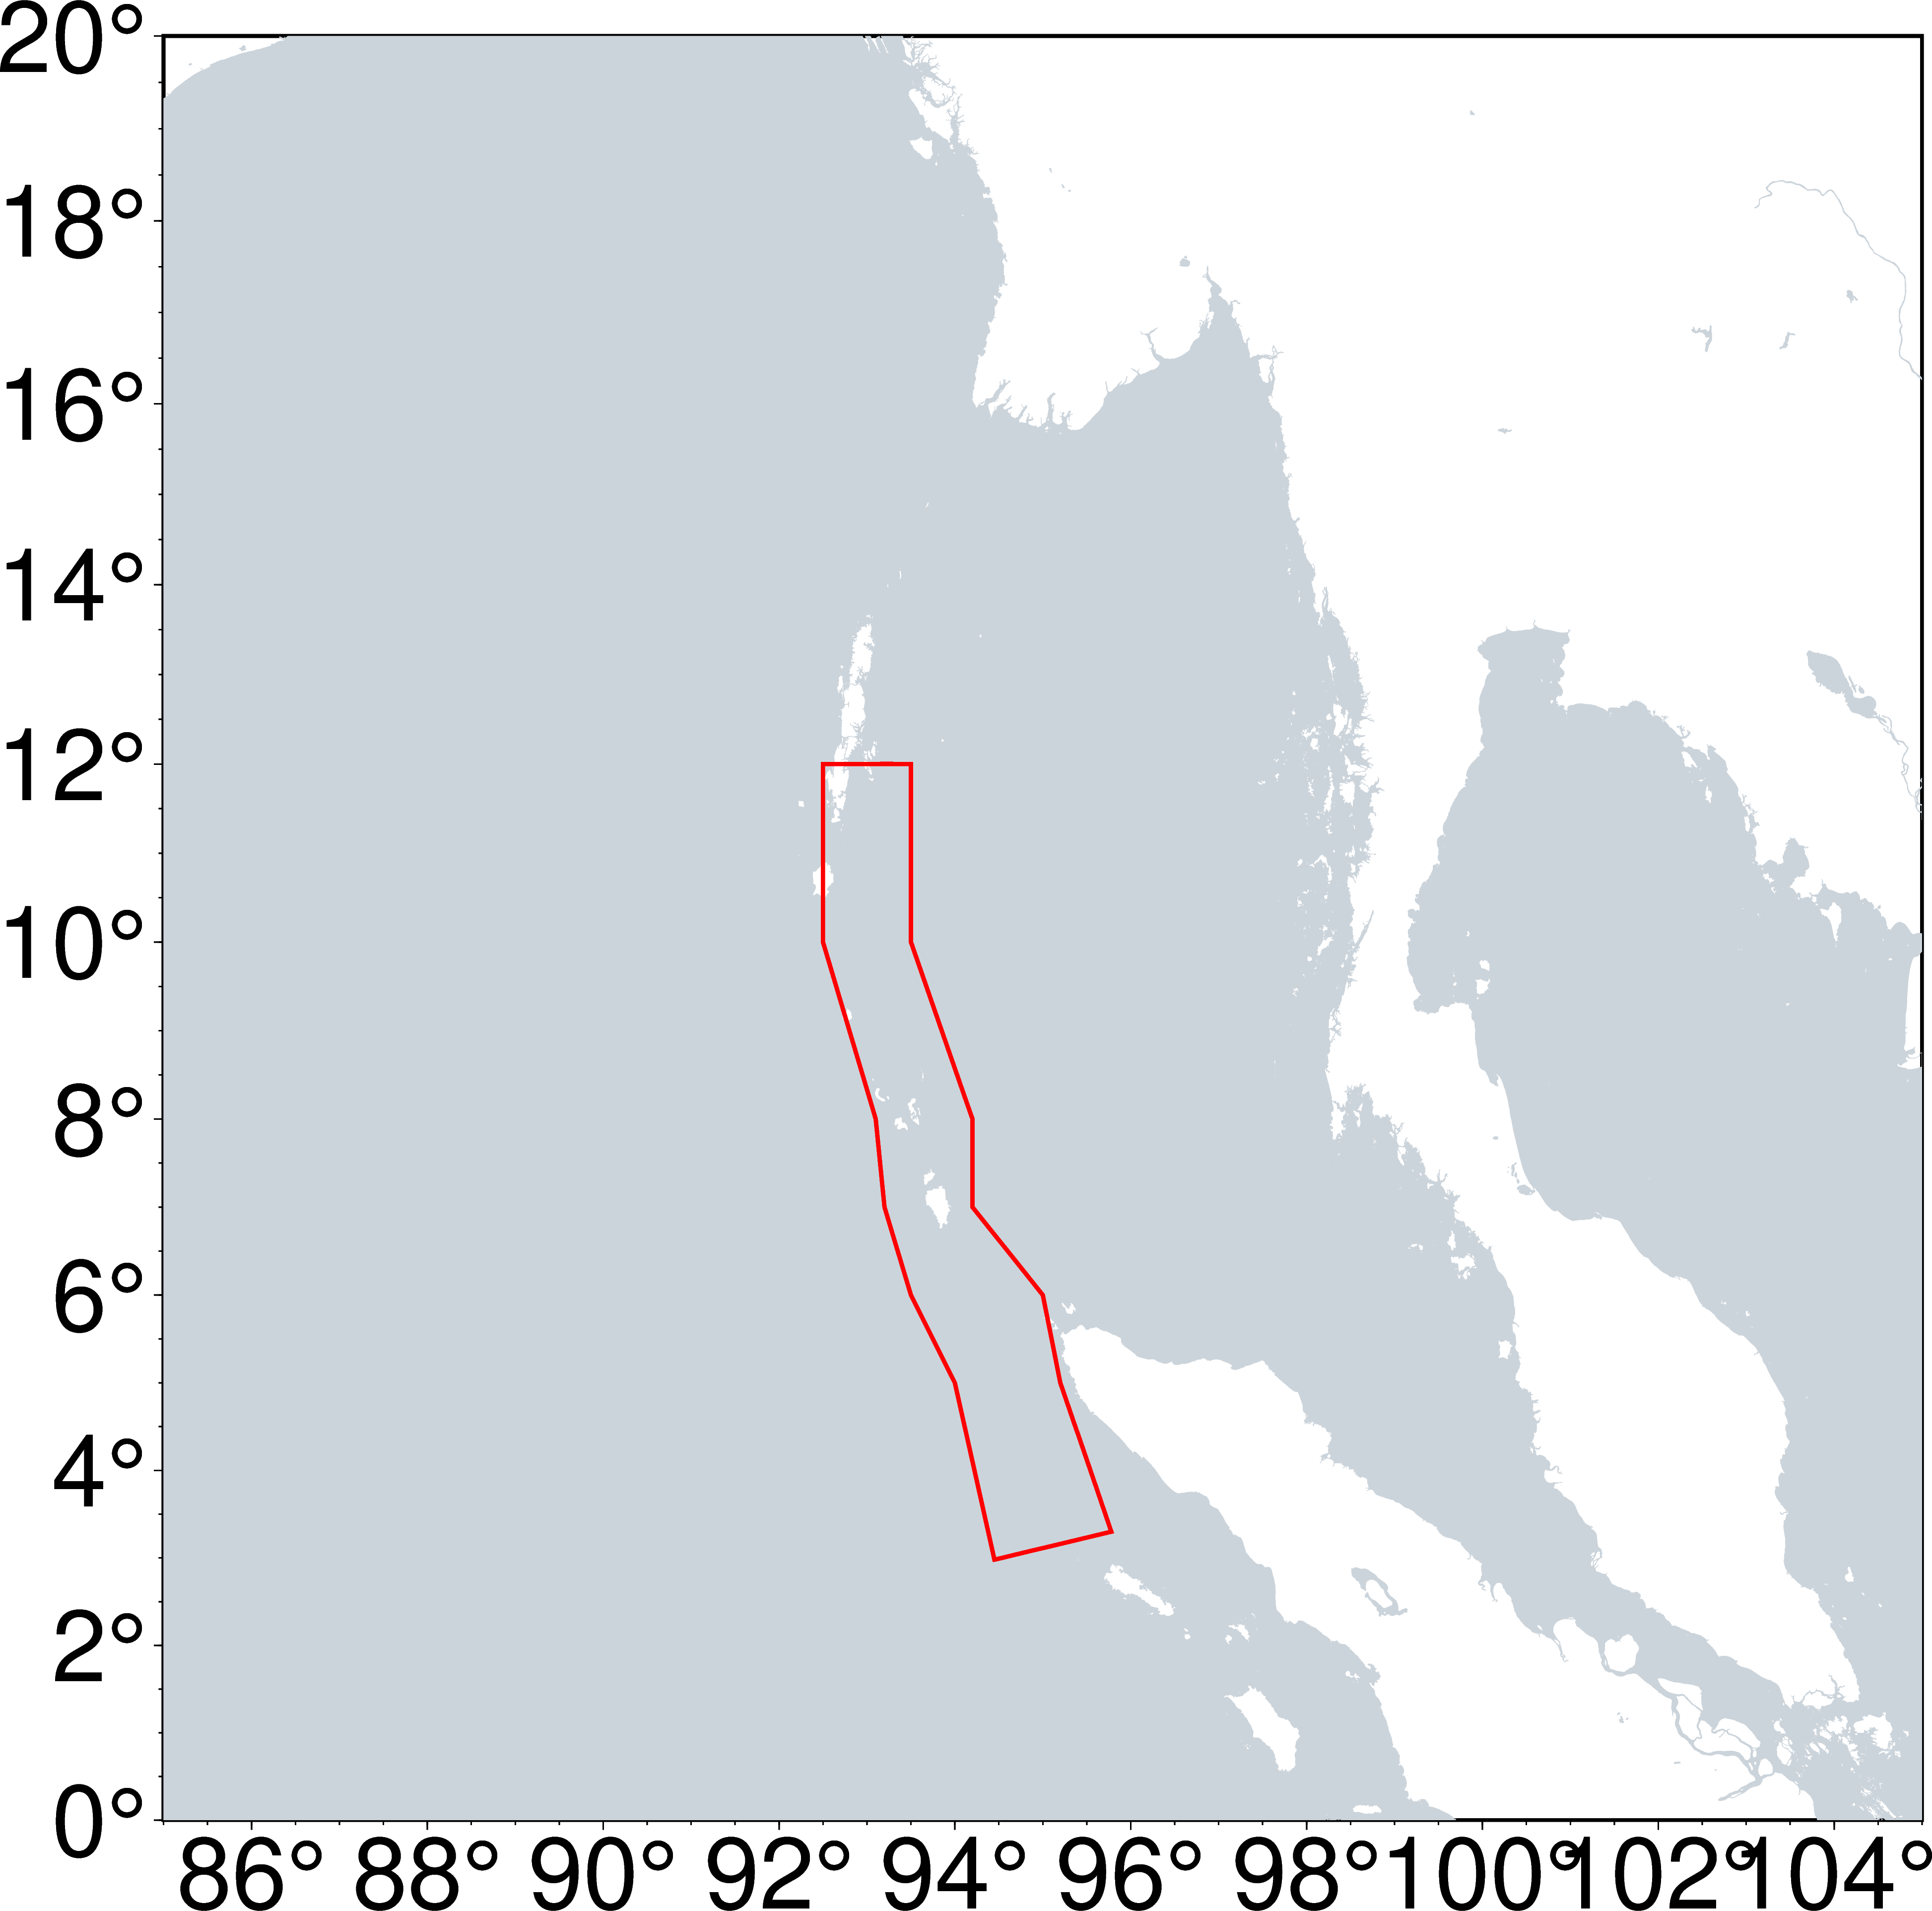

In [16]:
import pygmt
# Initialize figure
fig = pygmt.Figure()
# Set PyGMT universal configurations
pygmt.config(FORMAT_GEO_MAP="ddd", MAP_FRAME_TYPE="plain", FONT="48p")
projection = 'M0/0/30c'
# rgn = [92, 100, 16, 26]  # xmin/xmax/ymin/ymax
BL = [46.570,151.572] # Bottom Left (lat, lon)
TR = [60.353,164.939] # Top Right (lat, lon)
# rgn = [BL[1], TR[1], BL[0], TR[0]]  # xmin/xmax/ymin/ymax
rgn = [85, 105, 0, 20]

# Basemap
fig.basemap(region=rgn, projection=projection, frame=["xa2f0.5", "ya2f0.5"])
fig.coast(shorelines=False, region=rgn, projection=projection, water='204/212/219')

# Plot the corners:

# Extract lon and lat from corners
lons = [pt[0] for pt in corners]
lats = [pt[1] for pt in corners]

# Plot the corners as a closed polygon (line)
fig.plot(x=lons, y=lats, pen="2p,red", close=True, label="Fault Plane")

fig.show()